In [1]:
import datetime
beg_script = datetime.datetime.now()

# Visualizing the booking history of the UHCW dataset
## Definitions
The **booking history** refers to the status as "available" or "booked" of the appointments in the dataset at the various data collection times.

The **final status** refers to whether an appointment was eventually booked or went unused.
  


## Imports

In [2]:
import os
import pytz
import pandas as pd
import UHCW
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [3]:
PROJECT_DIR = os.path.join(os.path.expanduser("~"), "Projects/UHCW")
IMG_DIR = os.path.join(PROJECT_DIR, "IMAGE_FILES")

STATUS_TO_VALUE = {'available': 0, 'booked': 1}

## Helper functions

In [4]:
def write_line_to_desc(col, text, file):
    """Convenience function to add one line to a file in a particular format."""
    file.write(
        "{0}{1}{2}\n".format(
            col.ljust(COL_WIDTH),
            VERT_SEP,
            text
        )
    )
def timedelta_strftime(duration):
    """Convenience function to string format a timedelta."""
    string = "{0} days {1} hours {2} minutes".format(
        duration.days,
        duration.seconds//3600,
        duration.seconds//60
    )
    return string

## Data

In [5]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
foldername = 'Projects/UHCW'
# Choose from among datasets of various sizes (various collection periods or centers)
# filename = 'appointments-tiny.csv'
filename = 'appointments-less-tiny.csv'
# filename = 'appointments-one-week-two-centers.csv'
# filename = 'appointments-24-hours.csv'
# filename = 'appointments-one-week.csv'
# filename = 'appointments-three-weeks.csv'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e9:
    print("Size of data file: {}GB.".format(filesize//1e9))
elif filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1e6))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1e3))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
raw_data.rename(
    index=str,
    columns={
        'center id': 'id',
        'test type': 'test',
        'appointment timestamp': 'appointment',
        'center age group': 'age group',
        'grab timestamp': 'grab'
    },
    inplace=True
)


Time: 16:46:03
Size of data file: 1.0MB.
Loading data...
CPU times: user 20 ms, sys: 3.63 ms, total: 23.6 ms
Wall time: 22.2 ms


## The schedule (restricted to shorter grab period)
The dataframe `schedule` is essentially `raw_data` after certain type conversion.  

*(The next cell prints the current time to remember when the following cell was run.)*

In [6]:
print(datetime.datetime.now().strftime("Current time: %Hh %Mm %Ss"))

Current time: 16h 46m 03s


In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17538 entries, 0 to 17537
Data columns (total 6 columns):
Unnamed: 0     17538 non-null int64
appointment    17538 non-null object
age group      17538 non-null object
id             17538 non-null int64
test           17538 non-null object
grab           17538 non-null object
dtypes: int64(2), object(4)
memory usage: 959.1+ KB


In [8]:
%%time

schedule = UHCW.prepare_UHCW_dataframe(raw_data)

16h46m03s: Make copy of data...
16h46m03s: Type conversion: 
16h46m03s: Column appointment:
16h46m03s: Convert to datetime...
16h46m03s: Convert to London timezone...
16h46m04s: Column grab:
16h46m04s: Convert to datetime...
16h46m04s: Localize to UTC and convert to London timezone...
CPU times: user 992 ms, sys: 46 ms, total: 1.04 s
Wall time: 1 s


In [9]:
print(datetime.datetime.now().strftime("End of preprocessing:  %Hh %Mm %Ss"))

End of preprocessing:  16h 46m 04s


## The working schedule

Only consider past appointments (and ignore "age group" info which we won't use):

In [10]:
last_grab = schedule['grab'].max()
s = schedule.query('appointment <= @last_grab').copy()
s.drop('age group', axis=1, inplace=True)

## Center info

In [11]:
center_test_types = s.groupby('id')['test'].unique().rename("test types").to_frame()#.reset_index()
center_test_types

,test types
id,
10188,"[Blood Test, INR Test]"
10207,[Blood Test]


## Number of appointments

In [12]:
s.groupby(['id', 'test'])['appointment'].nunique().to_frame()

appointment
id    test                   
10188 Blood Test           73
      INR Test             17
10207 Blood Test           59

## The timegrid
The `schedule` contains a row for each appointment available at the times of data collection.
The timegrid gives the status of the appointment as "available" or "booked" at all data collection times.
This is the **booking history** associated with the schedule.
We can also determine whether an appointment was eventually booked or went unused.

In [13]:
%%time
t = UHCW.get_timegrid(s)

16:46:04
Cartesian product grabs by appointments...
Ignore grabs past appointments...
Restrict to past appointments (on or before 2019-01-17 14:00:00+00:00)...
Add status...
CPU times: user 49.1 ms, sys: 5.7 ms, total: 54.8 ms
Wall time: 52.3 ms


## Visualizing the booking history

Plot the booking history for all centers and test types.  

Set `save_figure` to **True** to save plots as image files.
In this case, a brief description of the type of figure is appended to `DESCRIPTION-OF-RUNS.txt`.

10188
Blood Test
INR Test
10207
Blood Test


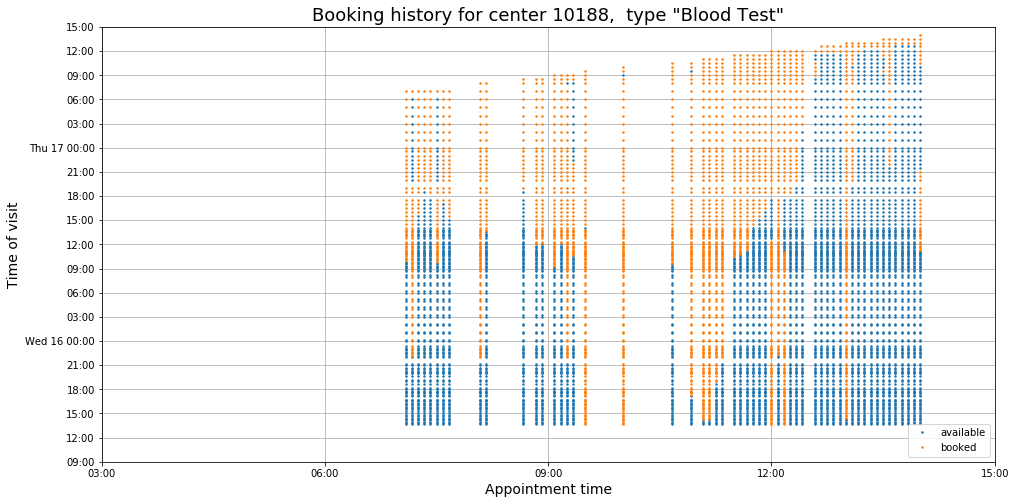

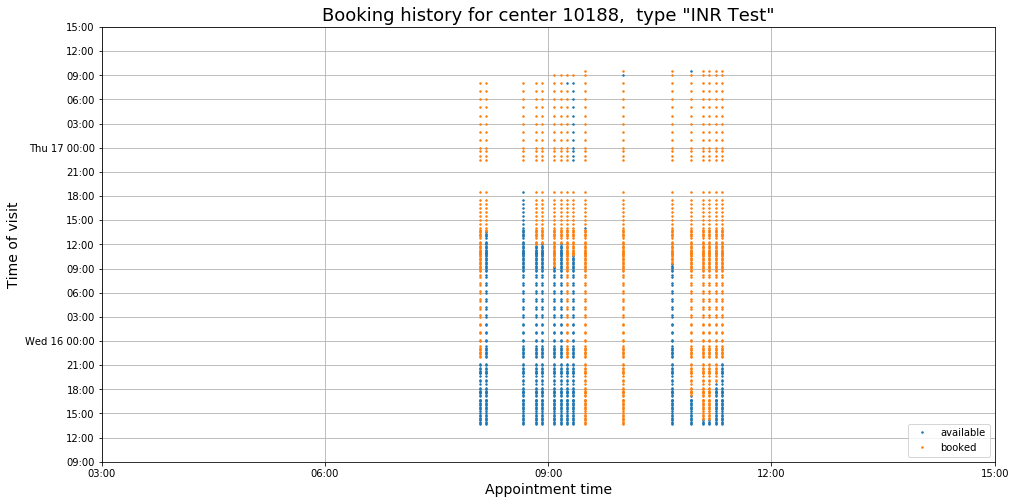

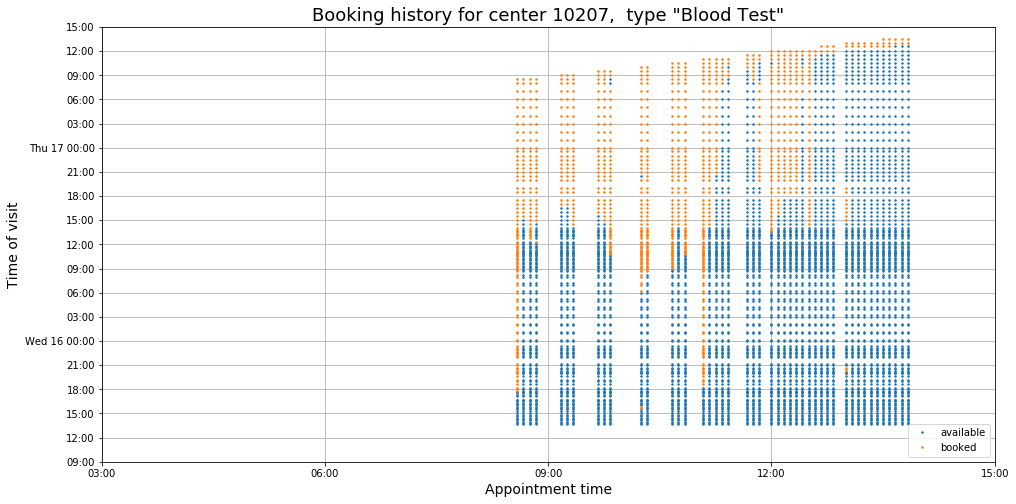

In [23]:
save_figure = False
FIG_SIZE = (16, 8)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "BOOKING HISTORY", descfile)
        write_line_to_desc("Nb rows", f.shape[0], descfile)

        first_grab = t['grab'].min()
        last_grab = t['grab'].max()
        grab_duration = last_grab - first_grab

        write_line_to_desc("Grab duration", timedelta_strftime(grab_duration), descfile)
        write_line_to_desc("First grab", first_grab, descfile)
        write_line_to_desc("Last grab", last_grab, descfile)

        first_appointment = t['appointment'].min()
        last_appointment= t['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)
        
x_date_range, x_tick_labels = UHCW.get_ticks(t['appointment'], freq='H')
y_date_range, y_tick_labels = UHCW.get_ticks(t['grab'], freq='H')
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        t0 = t.loc[(t['id'] == cid) & (t['test'] == test_type), t.columns]

        if t0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for status in ['available', 'booked']:
            tt0 = t0.loc[
                t0['status'] == status,
                ['appointment', 'grab']
            ].drop_duplicates()
            
            if tt0.empty:
                print(
                    'Remark: no data for status "{0}"'.format(
                    status
                    )
                )
                continue
            else:
                None
            
            legend_text.append(status)
            if status == 'available':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                tt0['appointment'],
                tt0['grab'],
                **{'marker': '.', 'markersize': 3, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='lower right')
        ax.set_title('Booking history for center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_xlim([x_date_range.min(), x_date_range.max()])
        ax.set_yticks(y_date_range);
        ax.set_yticklabels(y_tick_labels);
        ax.set_ylim([y_date_range.min(), y_date_range.max()])
        
        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-booking-history.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )        

## Calculating and visualizing the final status
The **final status** refers to whether an appointment was eventually booked or not.  

In [15]:
%%time
f = UHCW.get_final_status(t)

CPU times: user 62.1 ms, sys: 3.4 ms, total: 65.5 ms
Wall time: 58.5 ms


Set `save_figure` to **True** to save plots as image files.
In this case, a brief description of the type of figure is appended to `DESCRIPTION-OF-RUNS.txt`.

10188
Blood Test
Remark: no data for status "available"
INR Test
10207
Blood Test
Remark: no data for status "available"


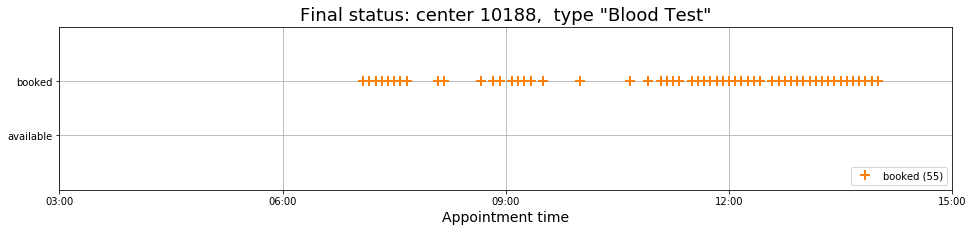

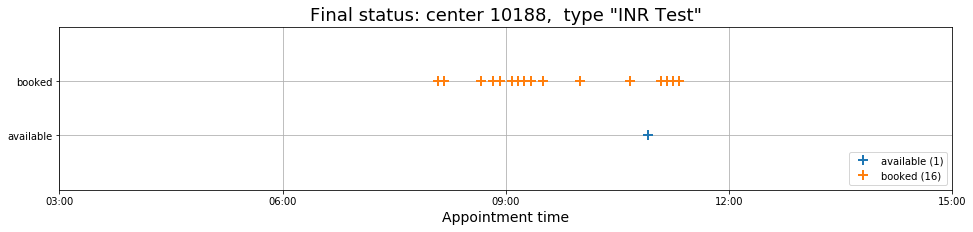

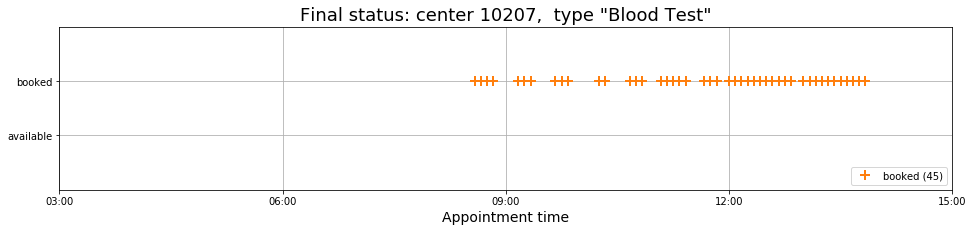

In [19]:
save_figure = False
FIG_SIZE = (16, 3)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "FINAL STATUS", descfile)
        write_line_to_desc("Nb rows", t.shape[0], descfile)

        first_grab = f['grab'].min()
        last_grab = f['grab'].max()
        grab_duration = last_grab - first_grab

        write_line_to_desc("Grab duration", timedelta_strftime(grab_duration), descfile)
        write_line_to_desc("First grab", first_grab, descfile)
        write_line_to_desc("Last grab", last_grab, descfile)

        first_appointment = f['appointment'].min()
        last_appointment= f['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)

x_date_range, x_tick_labels = UHCW.get_ticks(f['appointment'], freq='H')
# y_date_range, y_tick_labels = UHCW.get_ticks(f['grab'], freq='H')
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        f0 = f.loc[(f['id'] == cid) & (f['test'] == test_type), f.columns]

        if f0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for status in ['available', 'booked']:
            ff0 = f0.loc[
                f0['final status'] == status,
                ['appointment']
            ].drop_duplicates()
            
            if ff0.empty:
                print(
                    'Remark: no data for status "{0}"'.format(
                    status
                    )
                )
                continue
            else:
                None
            
            legend_text.append(" ".join([status, "({0})".format(ff0.shape[0])]))
            if status == 'available':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                ff0['appointment'],
                [STATUS_TO_VALUE[status]]*ff0.shape[0],
                **{'marker': '+', 'markersize': 10, 'markeredgewidth': 2, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='lower right')
        ax.set_title('Final status: center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        # ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_yticks([0, 1])
        ax.set_yticklabels(
            [{value: key for key, value in STATUS_TO_VALUE.items()}[idx] for idx in [0, 1]]
        )
        ax.set_ylim([-1, 2])
        ax.set_xlim([x_date_range.min(), x_date_range.max()])

        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-final-status.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )
            
            

## Calculating and visualizing the booking activity  
The **booking activity** refers to whether an appointment is being booked or cancelled.  

In [18]:
%%time
a = UHCW.get_activity(t)

CPU times: user 39.8 ms, sys: 3.76 ms, total: 43.5 ms
Wall time: 40.3 ms


10188
Blood Test
INR Test
10207
Blood Test


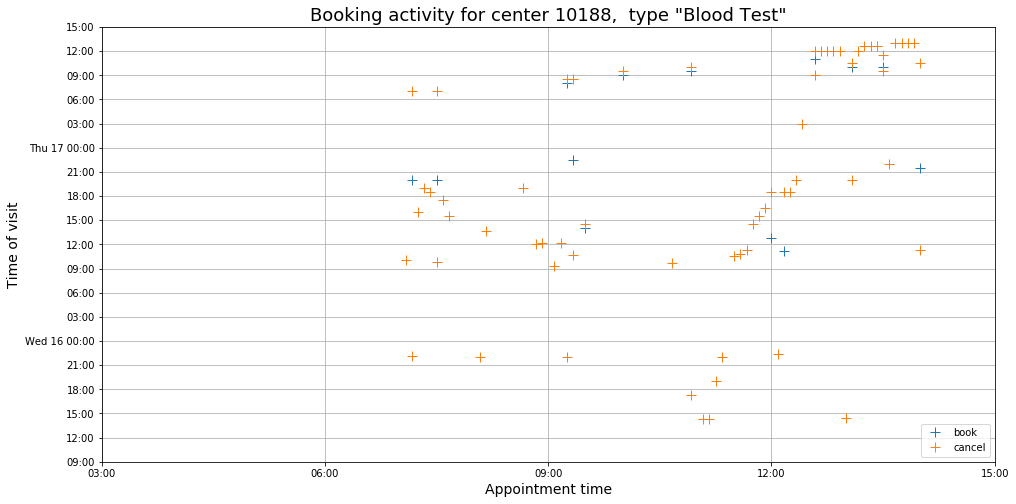

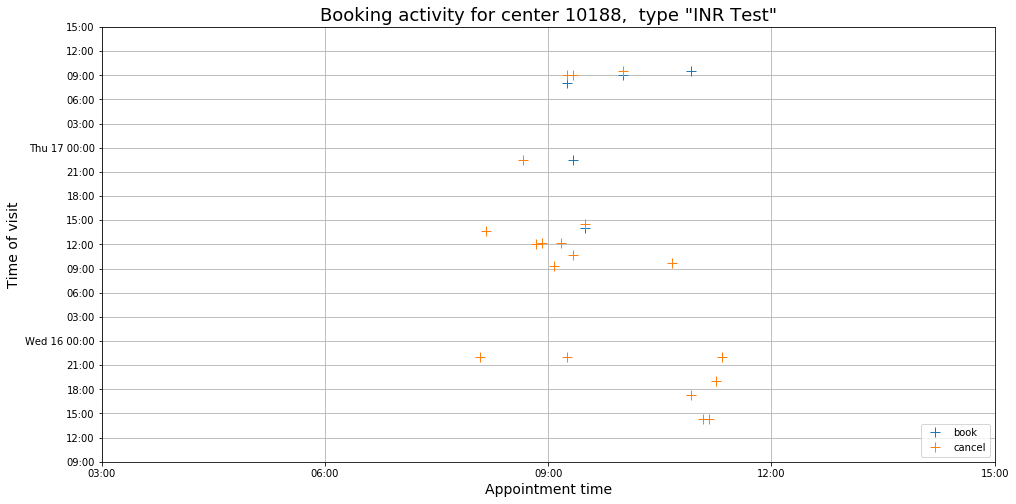

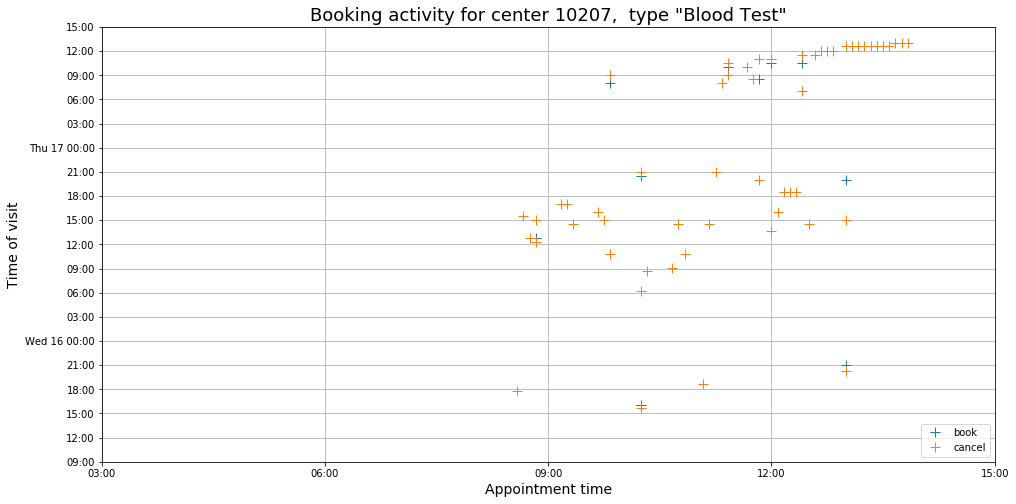

In [24]:
save_figure = False
FIG_SIZE = (16, 8)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "BOOKING ACTIVITY", descfile)
        write_line_to_desc("Nb rows", f.shape[0], descfile)

        first_grab = a['grab'].min()
        last_grab = a['grab'].max()
        grab_duration = last_grab - first_grab

        write_line_to_desc("Grab duration", timedelta_strftime(grab_duration), descfile)
        write_line_to_desc("First grab", first_grab, descfile)
        write_line_to_desc("Last grab", last_grab, descfile)

        first_appointment = a['appointment'].min()
        last_appointment= a['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)
        
x_date_range, x_tick_labels = UHCW.get_ticks(a['appointment'], freq='H')
y_date_range, y_tick_labels = UHCW.get_ticks(a['grab'], freq='H')
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        a0 = a.loc[(a['id'] == cid) & (a['test'] == test_type), a.columns]

        if a0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for action in ['book', 'cancel']:
            aa0 = a0.loc[
                a0['action'] == action,
                ['appointment', 'grab', 'action']
            ].drop_duplicates()
            
            if aa0.empty:
                print(
                    'Remark: no data for action "{0}"'.format(
                    action
                    )
                )
                continue
            else:
                None
            
            legend_text.append(action)
            if action == 'book':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                aa0['appointment'],
                aa0['grab'],
                **{'marker': '+', 'markersize': 10, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='lower right')
        ax.set_title('Booking activity for center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_xlim([x_date_range.min(), x_date_range.max()])
        ax.set_yticks(y_date_range);
        ax.set_yticklabels(y_tick_labels);
        ax.set_ylim([y_date_range.min(), y_date_range.max()])
        
        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-booking-history.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )   

In [17]:
end_script = datetime.datetime.now()

run_time = end_script - beg_script

print("This script ran for: {0}min {1}sec.".format(run_time.seconds//60, run_time.seconds%60))

with open(os.path.join(PROJECT_DIR, 'TIMING-OF-RUNS.txt'), 'a') as file:
    # file.write("timestamp,duration (sec),dataset,filesize (KB),first grab,last grab,first appointment,last appointment\n")
    

    file.write(
        ",".join(
            [
                beg_script.strftime("%Y-%m-%d %H:%M:%S"),
                str(run_time.seconds),
                filename,
                str(filesize),
                raw_data['grab'].min(),
                raw_data['grab'].max(),
                raw_data['appointment'].min(),
                raw_data['appointment'].max()
            ]
        )
    )
    file.write("\n")
    

This script ran for: 0min 3sec.
